In [ ]:
# %%capture
from google.colab import drive
drive.mount('/content/drive/')

import sys
sys.path.append('/content/drive/MyDrive/COMP576/training-logs/tensorboard')

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import numpy as np
import matplotlib.pyplot as plt

import re
import os
import datetime
from pytz import timezone

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models

tf.config.list_physical_devices('GPU')
!nvidia-smi

!pip install importnb
# import our preprocessing from ipynb
import sys
sys.path.append('drive/MyDrive/COMP576/final-project')
from importnb import Notebook
with Notebook():
    import KDR_Preprocessing as prep

Mounted at /content/drive/
Wed Dec  7 21:25:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |      3MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

# Helper functions

## Generate `data, train_data, test_data, uni_encoder, di_encoder`

* `data, train_data, test_data, uni_encoder, di_encoder = processing_folder(folder_path, sample_size, train_size)`

In [ ]:
def processing_folder(folder_path, sample_size, train_size):
    os.chdir(folder_path)
    files = sorted(os.listdir(folder_path), key=lambda x: int(re.findall(r'\d+', x)[0]))
    train_samples = []
    test_samples = []
    samples = []
    cols = []
    # text_count_id = 0
    for i, path in enumerate(files):
        if i >= sample_size:
            break
        with open(path, encoding='utf-8',           ##https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
                 errors='ignore') as f:
            lines = f.readlines()
        ## extract column names (once)
        if i == 0:
            ls = lines[0].split('\t')
            if re.findall(r'\w+|\d+', ls[-1]):
                ls[-1] = re.findall(r'\w+|\d+', ls[-1])[0]
                cols = ls
        ## extracting all samples from the current file
        sample = []
        curr_text_id = ''
        curr_index = -1
        for line in lines[1:]:
            ls = line.split('\t')
            if re.findall(r'\w+|\d+', ls[-1]):
                ls[-1] = re.findall(r'\w+|\d+', ls[-1])[0]
                if ls[1] != curr_text_id:
                    curr_index = 0
                    curr_text_id = ls[1]
                    # text_count_id += 1
                else:
                    curr_index += 1
                # ls.extend([curr_index, text_count_id])
                ls.append(curr_index)
                sample.append(ls)
        ##  split the current data into train-test-sets
        split_index = int(train_size * len(sample))
        train_samples = train_samples + sample[:split_index]
        test_samples = test_samples + sample[split_index:]
        samples = samples + sample
    ## forming dataframes
    df_all = pd.DataFrame(samples)
    df_train = pd.DataFrame(train_samples)
    df_test = pd.DataFrame(test_samples)
    ## renaming columns
    # cols = cols + ['INDEX'] + ['TEXT_COUNT_ID']
    cols = cols + ['INDEX']
    df_all.columns, df_train.columns, df_test.columns = cols, cols, cols
    ## construct onehot encoders from train data
    df_train['K1'], df_train['K2'] = df_train['KEYCODE'], df_train['KEYCODE']
    KEYCODE_enc = OneHotEncoder(handle_unknown='ignore').fit(df_train[['KEYCODE']])
    K1_enc = OneHotEncoder(handle_unknown='ignore').fit(df_train[['K1']])
    K2_enc = OneHotEncoder(handle_unknown='ignore').fit(df_train[['K2']])
    K1_K2_enc = OneHotEncoder(handle_unknown='ignore').fit(df_train[['K1', 'K2']])
    df_train = df_train.drop(columns=['K1', 'K2'])
    return df_all, df_train, df_test, KEYCODE_enc, K1_K2_enc, K1_enc, K2_enc

## Keyboard Dictionary

* `keyboard_dict = Keyboard(get_qwerty_keyboard()).keyboard_dict()`

In [ ]:
def get_qwerty_keyboard():
    first_row = [27, 27, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 0, 0, 145, 126, 0, 0, 0, 0, 0]
    space = [0] * 23
    second_row = [192, 49, 50, 51, 52, 53, 54, 55, 56, 57, 48, 189, 187, 8, 0, 45, 36, 33, 0, 144, 111, 106, 109]
    third_row = [9, 81, 87, 69, 82, 84, 89, 85, 73, 79, 80, 219, 221, 220, 0, 46, 35, 34, 0, 103, 104, 105, 107]
    fourth_row = [20, 65, 83, 68, 70, 71, 72, 74, 75, 76, 186, 222, 13, 13, 0, 0, 0, 0, 0, 100, 101, 102, 107]
    fifth_row = [16, 16, 90, 88, 67, 86, 66, 78, 77, 188, 190, 191, 16, 16, 0, 0, 38, 0, 0, 97, 98, 99, 13]
    sixth_row = [17, 17, 191, 18, 32, 32, 32, 32, 32, 18, 92, 93, 17, 17, 0, 37, 40, 39, 0, 96, 96, 110, 13]
    qwerty_keyboard = pd.DataFrame({'1st': first_row,
                                    'space': space,
                                    '2nd': second_row,
                                    '3rd': third_row,
                                    '4th': fourth_row,
                                    '5th': fifth_row,
                                    '6th': sixth_row}).transpose()
    qwerty_keyboard.index = list(range(7))
    return qwerty_keyboard

class Keyboard:
    def __init__(self, keyboard_df):
        self.keyboard = keyboard_df
        self.keycode_pos = self.get_keycode_pos()
    
    def get_keycode_pos(self):
        '''
        Generates Python dictionary encoding the keyboard keycode positions, i.e.
              - keys = javascript keycode
              - values = [i, j] of the corresponding keycode position on the keyboard
        Return: Python dict
        '''
        keyboard_dict = {}
        for row in self.keyboard.index:
            for col, entry in enumerate(self.keyboard.iloc[row, :]):
                if entry in keyboard_dict:
                    keyboard_dict[entry].append([row, col])
                else:
                    keyboard_dict[entry] = [[row, col]]
        return keyboard_dict
        
    def keycode_distance(self, keycode1, keycode2):
        '''
        Given a pair of keycodes, return their relative distance on the keyboard
        '''
        keycode1 = int(keycode1)
        keycode2 = int(keycode2)
        def manhattan_dist(arr1, arr2):
            return abs(arr1[0] - arr2[0]) + abs(arr1[1] - arr2[1])
        distance = 30 ## any integer larger than 22+6
        if keycode1 in self.keycode_pos and keycode2 in self.keycode_pos:
            for arr1 in self.keycode_pos[keycode1]:
                for arr2 in self.keycode_pos[keycode2]:
                    curr_dist = manhattan_dist(arr1, arr2)
                    if curr_dist < distance:
                        distance = curr_dist
            if distance < 5:
                return distance
        return 5
    
    def home_distance(self, keycode_list):
        '''
        Computes the AVERAGE distance of a list of keycodes to the home keys, where
        In QWERTY keyboard, F and J are the home keys with keycodes 70 and 74 resp.
        '''
        sum = 0
        for key in keycode_list:
            key = int(key)
            sum += min([self.keycode_distance(70, key), self.keycode_distance(74, key)])
        return sum/len(keycode_list)
    
    def keyboard_dict(self):
        return {'keycode': self.keycode_distance, 'home': self.home_distance}

## Extractor 

* `train_extractor = Extractors(train_data, keyboard_dict, avg_mode, add_layout, remove_outliers, conn_latency)`

* unigraph dataframe = `train_extractor.unigraph`
* digraph dataframe = `train_extractor.digraph`
* key-only dataframe (i.e. unigraph with no PL) = `train_extractor.key_only`

In [ ]:
class Extractors:
    def __init__(self, sub_data, keyboard_dict, latencies):
        self.keyboard_dict = keyboard_dict
        self.latencies = latencies

        self.unigraph = self.unigraph_extractor(sub_data)
        self.digraph = self.digraph_extractor(sub_data)
    
    def unigraph_extractor(self, df, user_str=True, keycode_str=True, drop_user=False):
        df = df[['PARTICIPANT_ID', 'TEST_SECTION_ID', 'PRESS_TIME', 'RELEASE_TIME', 'KEYCODE', 'INDEX']]
        df = df.astype('float64')
        if user_str:
            df['PARTICIPANT_ID'] = df['PARTICIPANT_ID'].astype('int64').astype(str)
        df = df.rename(columns={'PARTICIPANT_ID': 'USER'})
        if drop_user:
            df = df.drop(columns=['USER'])
        if keycode_str:
            df['KEYCODE'] = df['KEYCODE'].astype('int64').astype(str)
        ## construct new features
        if 'HL' in self.latencies:
            df['HL'] = df['RELEASE_TIME'] - df['PRESS_TIME']
        if 'IL' in self.latencies:
            df['IL'] = pd.concat([df['PRESS_TIME'][1:], pd.Series([0])], ignore_index=True) - df['RELEASE_TIME']
        if 'RL' in self.latencies:
            df['RL'] = pd.concat([df['RELEASE_TIME'][1:], pd.Series([0])], ignore_index=True) - df['RELEASE_TIME']
        if 'PL' in self.latencies:
            df['PL'] = pd.concat([df['PRESS_TIME'][1:], pd.Series([0])], ignore_index=True) - df['PRESS_TIME']
        ## dropping rows where the NEXT row has INDEX==0 (indicating a transition to next sentence)
        shift_txt = pd.concat([df['TEST_SECTION_ID'][1:], df['TEST_SECTION_ID'][-1:]], ignore_index=True) - df['TEST_SECTION_ID']
        mask = shift_txt == 0
        df = df.loc[mask]
        ## cleaning irrelavant info
        df = df.drop(columns=['PRESS_TIME', 'RELEASE_TIME', 'TEST_SECTION_ID'])
        df = df.iloc[:-1, :]
        return df
    
    def digraph_extractor(self, df, user_str=True, keycode_str=True, drop_user=False):
        df = df[['PARTICIPANT_ID', 'TEST_SECTION_ID', 'PRESS_TIME', 'RELEASE_TIME', 'KEYCODE', 'INDEX']]
        df = df.astype('float64')
        if user_str:
            df['PARTICIPANT_ID'] = df['PARTICIPANT_ID'].astype('int64').astype(str)
        df = df.rename(columns={'PARTICIPANT_ID': 'USER'})
        if drop_user:
            df = df.drop(columns=['USER'])
        ## construct new features
        df['K1'] = df['KEYCODE']
        df['K2'] = pd.concat([df['KEYCODE'][1:], pd.Series([0])], ignore_index=True)
        if keycode_str:
            df['K1'] = df['K1'].astype('int64').astype(str)
            df['K2'] = df['K2'].astype('int64').astype(str)
        df['I1'] = df['INDEX']
        df['I2'] = pd.concat([df['INDEX'][1:], pd.Series([0])], ignore_index=True)
        if 'HL' in self.latencies:
            df['HL1'] = df['RELEASE_TIME'] - df['PRESS_TIME']
            df['HL2'] = pd.concat([df['HL1'][1:], pd.Series([0])], ignore_index=True)
        if 'IL' in self.latencies:
            df['IL'] = pd.concat([df['PRESS_TIME'][1:], pd.Series([0])], ignore_index=True) - df['RELEASE_TIME']
        if 'RL' in self.latencies:
            df['RL'] = pd.concat([df['RELEASE_TIME'][1:], pd.Series([0])], ignore_index=True) - df['RELEASE_TIME']
        if 'PL' in self.latencies:
            df['PL'] = pd.concat([df['PRESS_TIME'][1:], pd.Series([0])], ignore_index=True) - df['PRESS_TIME']
        ## dropping instances where I2 is zero (indicating a transition to next sentence)
        shift_txt = pd.concat([df['TEST_SECTION_ID'][1:], df['TEST_SECTION_ID'][-1:]], ignore_index=True) - df['TEST_SECTION_ID']
        mask = shift_txt == 0
        df = df.loc[mask]
        ## cleaning irrelavant info
        df = df.drop(columns=['PRESS_TIME', 'RELEASE_TIME', 'KEYCODE', 'INDEX', 'TEST_SECTION_ID'])
        df = df.iloc[:-1, :]
        return df
    
    ## https://towardsdatascience.com/do-you-use-apply-in-pandas-there-is-a-600x-faster-way-d2497facfa66
    def digraph_avg(self, avg_mode, data=None, drop_origin=True, rename_avg=True, round_avg=True):
        if data:
            df = data.copy()
        else:
            df = self.digraph.copy()
        df['K1_K2'] = df[['K1', 'K2']].apply(tuple, axis=1)
        latencies = self.latencies.copy()
        if 'HL' in latencies:
            latencies.remove('HL')
            latencies.insert(0, 'HL2')
            latencies.insert(0, 'HL1')
        for XL in latencies:
            df[XL+'_avg'] = df[XL]
        for pair in df['K1_K2'].unique():
            mask = df['K1_K2'] == pair
            if avg_mode == 'mean':
                avg_df = df.loc[mask, latencies].mean()
            else:
                avg_df = df.loc[mask, latencies].median()
            for XL in latencies:
                df.loc[mask, XL+'_avg'] = avg_df[XL]
        if round_avg:
            for XL in latencies:
                df[XL+'_avg'] = round(df[XL+'_avg'])
        if drop_origin:
            df = df.drop(columns=latencies+['K1_K2'])
        if drop_origin and rename_avg:
            df = df.rename(columns=lambda name: re.search(r'(.{2,3})(_avg)', name).group(1) if '_avg' in name else name)
        return df

    def unigraph_avg(self, avg_mode, data=None, drop_origin=True, rename_avg=True, round_avg=True):
        if data:
            df = data.copy()
        else:
            df = self.unigraph.copy()
        for XL in self.latencies:
            df[XL+'_avg'] = df[XL]
        for keycode in df['KEYCODE'].unique():
            mask = df['KEYCODE'] == keycode
            if avg_mode == 'mean':
                avg_df = df.loc[mask, self.latencies].mean()
            else:
                avg_df = df.loc[mask, self.latencies].median()
            for XL in self.latencies:
                df.loc[mask, XL+'_avg'] = avg_df[XL]
        if round_avg:
            for XL in self.latencies:
                df[XL+'_avg'] = round(df[XL+'_avg'])
        if drop_origin:
            df = df.drop(columns=self.latencies)
        if drop_origin and rename_avg:
            df = df.rename(columns=lambda name: name[:2] if '_avg' in name else name)
        return df
    
    def digraph_encode_keyboard(self):
        df = self.digraph.copy()
        keycode_dist = []
        home_dist = []
        for row in df.index:
            keycode_dist.append(self.keyboard_dict['keycode'](df['K1'][row], df['K2'][row]))
            home_dist.append(self.keyboard_dict['home']([df['K1'][row], df['K2'][row]]))
        df['KD'] = keycode_dist
        df['HD'] = home_dist
        # cols = list(df.columns[:-5]) + list(df.columns[-2:]) + list(df.columns[-5:-2])
        num_cols = len(df.columns)
        cols = list(df.columns[:num_cols-2-(len(self.latencies)+1)]) + list(df.columns[-2:]) + list(df.columns[-2-(len(self.latencies)+1):-2])
        df = df[cols]
        return df
    
    def unigraph_encode_keyboard(self):
        df = self.unigraph.copy()
        home_dist = []
        for row in df.index:
            home_dist.append(self.keyboard_dict['home']([df['KEYCODE'][row]]))
        df['HD'] = home_dist
        # cols = list(df.columns[:-3]) + list(df.columns[-1:]) + list(df.columns[-3:-1])
        num_cols = len(df.columns)
        cols = list(df.columns[:num_cols-1-len(self.latencies)]) + list(df.columns[-1:]) + list(df.columns[-1-len(self.latencies):-1])
        df = df[cols]
        return df
    
    def filter_by_IQRs(self, data, folds, latencies):
        df = data.copy()
        for fold, latency in zip(folds, latencies):
            for user in data['USER'].unique():
                mask_user = data['USER'] == user
                mask_non_user = data['USER'] != user
                Q3 = data.loc[mask_user, latency].quantile(.75)
                Q1 = data.loc[mask_user, latency].quantile(.25)
                IQR = Q3 - Q1
                max = Q3 + fold * IQR
                min = Q1 - fold * IQR
                mask_max = data[latency] <= max
                mask_min = data[latency] >= min
                df = df.loc[mask_user & mask_max & mask_min | mask_non_user]
        return df

## KDS_generator

* `train_kds_uni = KDS(train_df_uni, n_steps, shift, batch_size, encoder=encoder_uni, mode='uni')`

* input shapes = `train_kds_uni.inputA`, `train_kds_uni.inputB`, `train_kds_uni.output`
* dataset input = `train_kds_uni.ds_in`
* dataset output = `train_kds_uni.ds_out`
* dataset (zipped) = `train_kds_uni.ds`

In [ ]:
class KDS:
    def __init__(self, df, output_dim, n_steps, shift, batch_size, encoders, enc_names, do_onehot=True):
        self.df = df
        self.window_length = n_steps + 1
        self.n_steps = n_steps
        self.shift = shift
        self.batch = batch_size
        self.output_dim = output_dim
        
        for i, user in enumerate(self.df['USER'].unique()):
            mask = self.df['USER'] == user
            curr_df = self.df.loc[mask, :].drop(columns=['USER'])
            ## One-hot on 'KEYCODE' (mode=='uni') OR 'K1', 'K2' (mode!='uni')
            if len(encoders) == 1 and enc_names[0] == 'KEYCODE':
                curr_df = np.concatenate([encoders[0].transform(curr_df[['KEYCODE']].astype(str)).toarray(), curr_df.drop(columns=['KEYCODE'])], axis=1)
            elif len(encoders) == 1 and enc_names[0] == 'K1_K2':
                curr_df = np.concatenate([encoders[0].transform(curr_df[['K1', 'K2']].astype(str)).toarray(), curr_df.drop(columns=['K1', 'K2'])], axis=1)
            else:
                k1_onehot = encoders[0].transform(curr_df[['K1']].astype(str)).toarray()
                k2_onehot = encoders[1].transform(curr_df[['K2']].astype(str)).toarray()
                curr_df = np.concatenate([k1_onehot+k2_onehot, curr_df.drop(columns=['K1', 'K2'])], axis=1)
            ## get the TFDS dataset of inputs (inputA, inputB) and output
            curr_in, curr_out = self.get_dataset(curr_df)
            if i == 0:
                self.ds_in = curr_in
                self.ds_out = curr_out
            else:
                self.ds_in = self.ds_in.concatenate(curr_in)
                self.ds_out = self.ds_out.concatenate(curr_out)
        ## zip the TFDS inputs and output for easy access at training
        self.ds = tf.data.Dataset.zip((self.ds_in, self.ds_out))
        
        for inputA, inputB in self.ds_in.take(1):
            self.inputA = inputA.shape
            self.inputB = inputB.shape
        
        for output in self.ds_out.take(1):
            self.output = output.shape

    def get_dataset(self, df):
        dataset = tf.data.Dataset.from_tensor_slices(df).window(size=self.window_length, shift=self.shift, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(self.window_length)).batch(self.batch)
        ds_in = dataset.map(lambda window: (window[:, :self.n_steps, :], window[:, -1, :-self.output_dim]))
        ds_in = ds_in.prefetch(tf.data.AUTOTUNE)
        ds_out = dataset.map(lambda window: window[:, -1, -self.output_dim:])
        ds_out = ds_out.prefetch(tf.data.AUTOTUNE)
        return ds_in, ds_out

## KDI_generator

In [ ]:
class KDI:
    def __init__(self, train_data, df, n_steps, batch_size, mat_length, 
                 inputA_features, inputB_features, output_features, 
                 inputB_type='image', encoders=None, keep_smaller_window=False, add_UNK=True):
        self.train_data = train_data
        self.df = df
        self.window_length = n_steps + 1
        self.batch_size = batch_size
        self.mat_length = mat_length

        self.inputA_features = inputA_features
        self.inputB_features = inputB_features
        self.inputB_type = inputB_type                ## 'image', or 'onehot', else default to 'int'
        self.output_features = output_features        ## output_features ('HL', 'XL' in ['PL', 'RL', 'IL'])

        self.encoders = encoders
        self.keep_smaller_window = keep_smaller_window
        self.add_UNK = add_UNK

        self.keycode_dict = self.keycode_topfreq_dict(top=self.mat_length-1)

        self.inputA, self.inputB, self.output = self.kdi_training_data()
        self.ds = self.generate_kds()


    def keycode_topfreq_dict(self, top):
        '''
        generate dictionary for the most popular `top` many keycodes using training data
        '''
        keycode_dict = {keycode: i for i, keycode in enumerate(self.train_data['KEYCODE'].astype('int32').value_counts()[:top].to_dict().keys())}
        if self.add_UNK:
            keycode_dict[0] = len(keycode_dict)
        return keycode_dict
  

    def single_input_image(self, curr_chunk, features, mat_length, keycode_dict):
        mat_dict = {}
        for feature in features:
            mat_dict['mat_'+feature] = np.zeros((mat_length, mat_length))
        mat_dict['count'] = np.zeros((mat_length, mat_length))

        for row in curr_chunk.index:
            i = int(curr_chunk.loc[row, 'K1'])
            j = int(curr_chunk.loc[row, 'K2'])
            if i in keycode_dict:
                pos_i = keycode_dict[i]
            else:
                pos_i = keycode_dict[0]   ## pos_i = top (the last key-value pair)
            if j in keycode_dict:
                pos_j = keycode_dict[j]
            else:
                pos_j = keycode_dict[0]
            for feature in features:
                if feature != 'HL':
                    mat_dict['mat_'+feature][pos_i, pos_j] += curr_chunk.loc[row, feature]
                else:
                    mat_dict['mat_'+feature][pos_i, pos_j] += (i + j) / 2
            mat_dict['count'][pos_i, pos_j] += 1
        mask_nonzero = mat_dict['count'] != 0
        mat_ls = []
        for feature in features:
            mat_dict['mat_'+feature][mask_nonzero] = mat_dict['mat_'+feature][mask_nonzero] / mat_dict['count'][mask_nonzero]
            mat_ls.append(mat_dict['mat_'+feature])
        return np.stack(mat_ls, axis=-1)
    

    def single_kdi_input(self, curr_chunk):
        last_index = curr_chunk.index[-1]
        output_ls = []
        for feature in self.output_features:
            output_ls.append(curr_chunk.loc[last_index, feature])
        output_np = np.array(output_ls)
        ## inputA 
        inputA = self.single_input_image(curr_chunk.iloc[:-1], self.inputA_features, self.mat_length, self.keycode_dict)
        ## inputB
        if self.inputB_type == 'image':
            inputB = self.single_input_image(curr_chunk.iloc[-1:], self.inputB_features, self.mat_length, self.keycode_dict)
        elif self.inputB_type == 'onehot' and self.encoders:
            if len(self.encoders) == 1:
                inputB_keycode = self.encoders[0].transform(curr_chunk.loc[[last_index], ['K1', 'K2']].astype(str)).toarray()
            else:
                inputB_k1 = self.encoders[0].transform(curr_chunk.loc[[last_index], ['K1']].astype(str)).toarray()
                inputB_k2 = self.encoders[1].transform(curr_chunk.loc[[last_index], ['K2']].astype(str)).toarray()
                inputB_keycode = inputB_k1 + inputB_k2
            inputB = np.concatenate([inputB_keycode, np.array(curr_chunk.loc[last_index, self.inputB_features])], axis=1)
        else:
            inputB = np.array(curr_chunk.loc[last_index, self.inputB_features + ['K1', 'K2']])
        return inputA, inputB, output_np
    

    def kdi_training_data(self):
        window_length = self.n_steps + 1
        inputA_arr, inputB_arr, output_arr = [], [], []
        for user in self.df['USER'].unique():
            curr_df = self.df[self.df['USER'] == user]
            i = 0
            while i+window_length < len(curr_df):
                curr_chunk = curr_df.iloc[i:i+window_length]
                curr_inputA, curr_inputB, curr_output = self.single_kdi_input(curr_chunk)
                inputA_arr.append(curr_inputA)
                inputB_arr.append(curr_inputB)
                output_arr.append(curr_output)
                i += self.shift
            if self.keep_smaller_window and i < len(curr_df) - 1:    ## i cannot be curr_df[-1:] of length 1, since impossible to split into input and output data
                curr_chunk = curr_df.iloc[i:]
                curr_inputA, curr_inputB, curr_output = self.single_kdi_input(curr_chunk)
                inputA_arr.append(curr_inputA)
                inputB_arr.append(curr_inputB)
                output_arr.append(curr_output)
        return np.stack(inputA_arr, axis=0), np.stack(inputB_arr, axis=0), np.stack(output_arr, axis=0)
    

    def generate_kds(self):
        dataset = tf.data.Dataset.from_tensor_slices(({'inputA': self.inputA, 'inputB': self.inputB}, 
                                                      self.output)).batch(self.batch_size)
        return dataset

## Callbacks 

* `get_callbacks(experiment_name, patience, avg_mode)`
  * `create_checkpoint_callback(experiment_name, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)`
  * `create_tensorboard_callback(experiment_name)`
  * `create_earlystopping_callback(monitor='val_loss', patience=5)`

In [ ]:
## functionalize callbacks
def create_checkpoint_callback(experiment_name, 
                               avg_mode,
                               save_weights_only=True, 
                               monitor='val_loss', 
                               mode='min', 
                               save_best_only=True):
    path = '/content/drive/MyDrive/COMP576/experiments'
    now_time = datetime.datetime.now(timezone('America/Chicago'))
    checkpoint_filepath = path + "/" + "checkpoints" + "/" + experiment_name + "/" + now_time.strftime("%Y%m%d-%H%M%S")
    checkpoint_filepath = checkpoint_filepath + '-avg' if avg_mode else checkpoint_filepath
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                             save_weights_only=save_weights_only,
                                                             monitor=monitor,
                                                             mode=mode,
                                                             save_best_only=save_best_only)
    print(f"Saving ModelCheckpoint files to :{checkpoint_filepath}")
    return checkpoint_callback

def create_tensorboard_callback(experiment_name, avg_mode):
    path = '/content/drive/MyDrive/COMP576/experiments'
    now_time = datetime.datetime.now(timezone('America/Chicago'))
    log_dir = path + "/" + "tensorboard" + "/" + experiment_name + "/" + now_time.strftime("%Y%m%d-%H%M%S")
    log_dir = log_dir + '-avg' if avg_mode else log_dir
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to :{log_dir}")
    return tensorboard_callback

def create_earlystopping_callback(patience, monitor='val_loss'):
    return tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

def get_callbacks(experiment_name, patience, avg_mode):
    earlystopping = create_earlystopping_callback(patience)
    modelcheckpoint = create_checkpoint_callback(experiment_name=experiment_name, avg_mode=avg_mode)
    tensorboard = create_tensorboard_callback(experiment_name=experiment_name, avg_mode=avg_mode)
    return [earlystopping, modelcheckpoint, tensorboard]

## Baseline Model

* `model = create_model(feature_dim, output_dim, user_embedding=None, keycode_embedding=None, concat_model=None)`
  * `typenet_base`
  * `concate_RNN_base`

* `feature_dim = train_kds_uni.inputA[-1]`
* `output_dim = train_kds_uni.output[-1]`

In [ ]:
def typenet_base(inputA):
    name = 'TypeNet-base'
    batch_1 = keras.layers.BatchNormalization()(inputA)
    lstm_1 = keras.layers.LSTM(128, return_sequences=True)(batch_1)
    dropout_1 = keras.layers.Dropout(0.5)(lstm_1)
    batch_2 = keras.layers.BatchNormalization()(dropout_1)
    lstm_2 = keras.layers.LSTM(128)(batch_2)
    return name, lstm_2

def concate_RNN_base(concat, feature_dim, output_dim):
    name = 'ConcatRNN-base'
    reshape = keras.layers.Reshape((128+feature_dim-output_dim, 1))(concat)
    gru_1 = keras.layers.GRU(64)(reshape)
    return name, gru_1

def create_model(feature_dim, output_dim, user_embedding=None, keycode_embedding=None, concat_model=None):
    inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
    inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')
    
    if user_embedding:
        user_name, user_embeded = user_embedding(inputA)
    else:
        user_name, user_embeded = 'no-user', inputA
    if keycode_embedding:
        keycode_name, keycode_embeded = keycode_embedding(inputB)
    else:
        keycode_name, keycode_embeded = 'no-keycode', inputB
    concat = keras.layers.concatenate([user_embeded, keycode_embeded])

    if concat_model:
        concat_name, concat_output = concat_model(concat, feature_dim, output_dim)
    else:
        concat_name, concat_output = 'no-concat', concat
    output = keras.layers.Dense(output_dim)(concat_output)

    model_name = user_name + '_' + keycode_name + '_' + concat_name
    return keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

# TensorBoard

In [ ]:
# %load_ext tensorboard

# # Clear any logs from previous runs
# rm -rf ./logs/

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# %tensorboard --logdir logs/fit

# from tensorboard import notebook
# notebook.list() # View open TensorBoard instances

# # Control TensorBoard display. If no port is provided, 
# # the most recently launched TensorBoard is used
# notebook.display(port=6006, height=1000)
# # !kill portPID#

# Old Experiments: `sample_size = 100`, `train_size = 0.8`

Goal: 
1. have a baseline learning rate (just use one set of parameters)
2. decide `avg` shoul be `mean` or `median`

Preping mode: 
* add_layout = False
* remove_outliers = 1
* conn_latency = 'PL'
* n_steps = 30
* shift = 1
* batch_size = 64

Total trainings: 8

## Setup

In [ ]:
## Data Loading Parameters
folder_path = "/content/drive/MyDrive/COMP576/keystroke-samples"      ## up to USER=7001 (inclusive)
train_size = 0.8
sample_size = 100

data, train_data, test_data, uni_encoder, di_encoder = prep.processing_folder(folder_path, sample_size, train_size)

print(f"There are in total {len(train_data['PARTICIPANT_ID'].unique())} many users contained in the train dataset")
print(f"There are in total {len(test_data['PARTICIPANT_ID'].unique())} many users contained in the test dataset")
print(f"There are in total {len(data['PARTICIPANT_ID'].unique())} many users contained in the entire dataset")
print(f"There are in total {len(data)} many keystrokes contained in the dataset")

There are in total 400 many users contained in the train dataset
There are in total 400 many users contained in the test dataset
There are in total 400 many users contained in the entire dataset
There are in total 294546 many keystrokes contained in the dataset


In [ ]:
latencies = ['HL', 'PL']
keyboard_dict = prep.Keyboard(prep.get_qwerty_keyboard()).keyboard_dict()
train_extractor = prep.Extractors(train_data, keyboard_dict, latencies)
test_extractor = prep.Extractors(test_data, keyboard_dict, latencies)

## Experiment 2: Uni-graph + Mean (fixed preprocessor problem on latencies between different sentences)

* avg_mode = 'mean'
* add_layout = False
* remove_outliers = 1
* conn_latency = 'PL'

* n_steps = 30
* shift = 1
* batch_size = 64

In [ ]:
avg_mode = 'mean'
train_df_uni_mean = train_extractor.unigraph_avg(avg_mode)
test_df_uni_mean = test_extractor.unigraph_avg(avg_mode)

In [ ]:
n_steps = 30
shift = 1
batch_size = 64

train_kds_uni_mean = prep.KDS(train_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')
test_kds_uni_mean = prep.KDS(test_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')

### Some STATs

In [ ]:
train_df_uni_mean.describe()

,USER,INDEX,HL,PL
count,58246.0,58246.0,58246.0,58246.0
mean,180.1,27.0,118.9,275.2
std,102.5,19.4,57.2,72.1
min,5.0,0.0,0.0,23.0
25%,88.0,11.0,105.0,232.0
50%,186.0,24.0,107.0,251.0
75%,275.0,39.0,113.0,284.0
max,346.0,134.0,1051.0,5329.0


### Training

#### Group 0: `uni_mean` (lr_scheduler to find a sensible learning rate)

In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]
user_gru = 64
concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
concat_output = keras.layers.GRU(concat_gru = 32)(reshape)

output = keras.layers.Dense(output_dim)(concat_output)

model_name = 'Exp2Gp0'
model_Exp2Gp0 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]

##change model name 1
model_Exp2Gp0 = prep.create_model(feature_dim, output_dim, 
                     user_embedding=prep.typenet_base, 
                     keycode_embedding=None, 
                     concat_model=prep.concate_RNN_base)

##------------------------------------------------------------------------------------------##
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 20
patience = 4

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    return round(0.1 ** num1 * num2, 7)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback('Exp1Gp0', avg_mode=True)

##change model name 2
model_Exp2Gp0.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 3 + 4
history_Exp2Gp0 = model_Exp2Gp0.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Exp1Gp0/20221206-194351-avg
Epoch 1/20
909/909 [==============================] - 42s 36ms/step - loss: 190.0348 - mae: 190.7277 - val_loss: 12577.2598 - val_mae: 12577.9531 - lr: 7.0000e-05
Epoch 2/20
909/909 [==============================] - 29s 32ms/step - loss: 182.6343 - mae: 183.3275 - val_loss: 12571.3613 - val_mae: 12572.0547 - lr: 1.0000e-04
Epoch 3/20
909/909 [==============================] - 30s 32ms/step - loss: 167.3489 - mae: 168.0419 - val_loss: 12548.9775 - val_mae: 12549.6699 - lr: 4.0000e-04
Epoch 4/20
909/909 [==============================] - 30s 33ms/step - loss: 134.3790 - mae: 135.0722 - val_loss: 12510.4941 - val_mae: 12511.1904 - lr: 7.0000e-04
Epoch 5/20
909/909 [==============================] - 29s 32ms/step - loss: 90.7684 - mae: 91.4449 - val_loss: 12476.4980 - val_mae: 12477.1875 - lr: 0.0010
Epoch 6/20
909/909 [==============================] - 31s 34ms/step - loss:

KeyboardInterrupt: ignored

## Experiment 1
-----
* train_kds_uni_mean
* test_kds_uni_mean
-----
* train_kds_di_mean
* test_kds_di_mean
-----
* train_kds_uni_median
* test_kds_uni_median
-----
* train_kds_di_median
* test_kds_di_median
-----

### Group 0: `uni_mean` (lr_scheduler to find a sensible learning rate)

In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]

model_Exp1Gp0 = create_model(feature_dim, output_dim, 
                     user_embedding=typenet_base, 
                     keycode_embedding=None, 
                     concat_model=concate_RNN_base)

##------------------------------------------------------------------------------------------##
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 20
patience = 4

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    return round(0.1 ** num1 * num2, 7)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = create_tensorboard_callback('Exp1Gp0', avg_mode=True)

model_Exp1Gp0.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history_Exp1Gp0 = model_Exp1Gp0.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Exp1Gp0/20221205-215531-avg
Epoch 1/20
933/933 [==============================] - 273s 285ms/step - loss: 5293.8481 - mae: 5294.5342 - val_loss: 10978.1299 - val_mae: 10978.8252 - lr: 7.0000e-05
Epoch 2/20
933/933 [==============================] - 260s 279ms/step - loss: 5289.5039 - mae: 5290.1992 - val_loss: 10972.6885 - val_mae: 10973.3799 - lr: 1.0000e-04
Epoch 3/20
933/933 [==============================] - 262s 280ms/step - loss: 5280.3691 - mae: 5281.0605 - val_loss: 10952.4404 - val_mae: 10953.1328 - lr: 4.0000e-04
Epoch 4/20
933/933 [==============================] - 264s 283ms/step - loss: 5260.9487 - mae: 5261.6377 - val_loss: 10918.8730 - val_mae: 10919.5586 - lr: 7.0000e-04
Epoch 5/20
933/933 [==============================] - 261s 280ms/step - loss: 5242.5581 - mae: 5243.2334 - val_loss: 10903.9209 - val_mae: 10904.6084 - lr: 0.0010
Epoch 6/20
933/933 [==============================] -

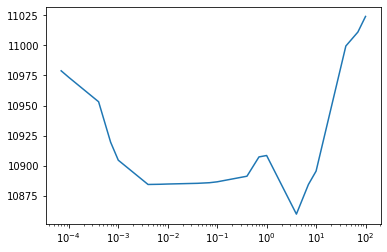

In [ ]:
# plot lr versus loss
lrs = history_Exp1Gp0.history['lr']
loss = history_Exp1Gp0.history['val_mae']
plt.semilogx(lrs, loss);

In [ ]:
# model_Exp1Gp0.predict(test_kds_uni_mean.ds_in.take(1))

### Group 1: `uni_median` (lr_scheduler to find a sensible learning rate)

In [ ]:
feature_dim = train_kds_uni_median.inputA[-1]
output_dim = train_kds_uni_median.output[-1]

model_Exp1Gp1 = create_model(feature_dim, output_dim, 
                     user_embedding=typenet_base, 
                     keycode_embedding=None, 
                     concat_model=concate_RNN_base)

##------------------------------------------------------------------------------------------##
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 20
patience = 4

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    return round(0.1 ** num1 * num2, 7)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = create_tensorboard_callback('Exp1Gp1', avg_mode=True)

model_Exp1Gp1.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history_Exp1Gp1 = model_Exp1Gp1.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Exp1Gp1/20221205-234331-avg
Epoch 1/20
933/933 [==============================] - 39s 32ms/step - loss: 5293.7686 - mae: 5294.4590 - val_loss: 10977.9072 - val_mae: 10978.5986 - lr: 7.0000e-05
Epoch 2/20
933/933 [==============================] - 28s 30ms/step - loss: 5289.3491 - mae: 5290.0479 - val_loss: 10972.6123 - val_mae: 10973.3047 - lr: 1.0000e-04
Epoch 3/20
933/933 [==============================] - 28s 30ms/step - loss: 5280.1108 - mae: 5280.7993 - val_loss: 10957.2227 - val_mae: 10957.9102 - lr: 4.0000e-04
Epoch 4/20
933/933 [==============================] - 33s 36ms/step - loss: 5260.6162 - mae: 5261.3091 - val_loss: 10925.7998 - val_mae: 10926.4922 - lr: 7.0000e-04
Epoch 5/20
933/933 [==============================] - 28s 30ms/step - loss: 5242.4805 - mae: 5243.1543 - val_loss: 10903.9971 - val_mae: 10904.6836 - lr: 0.0010
Epoch 6/20
933/933 [==============================] - 27s 29ms/

In [ ]:
for a, b in test_kds_uni_mean.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds_uni_mean.ds_out.take(1):
    output = a

model_Exp1Gp1.predict((inputA, inputB)), output

2/2 [==============================] - 0s 10ms/step


(array([[  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.2781 ],
        [  407.36996,  -370.

In [ ]:
inputA, inputB

(<tf.Tensor: shape=(64, 30, 80), dtype=float64, numpy=
 array([[[   0.,    0.,    0., ...,    7.,  131.,  272.],
         [   0.,    0.,    0., ...,    8.,   99.,  265.],
         [   0.,    0.,    0., ...,    9.,   99.,  265.],
         ...,
         [   0.,    0.,    0., ...,    5.,  106.,  311.],
         [   0.,    0.,    0., ...,    6.,  124.,  267.],
         [   0.,    0.,    0., ...,    7.,  111.,  241.]],
 
        [[   0.,    0.,    0., ...,    8.,   99.,  265.],
         [   0.,    0.,    0., ...,    9.,   99.,  265.],
         [   0.,    0.,    0., ...,   10.,  106.,  311.],
         ...,
         [   0.,    0.,    0., ...,    6.,  124.,  267.],
         [   0.,    0.,    0., ...,    7.,  111.,  241.],
         [   0.,    0.,    0., ...,    8.,   99.,  262.]],
 
        [[   0.,    0.,    0., ...,    9.,   99.,  265.],
         [   0.,    0.,    0., ...,   10.,  106.,  311.],
         [   0.,    0.,    0., ...,   11.,   96.,  804.],
         ...,
         [   0.,    0.,    

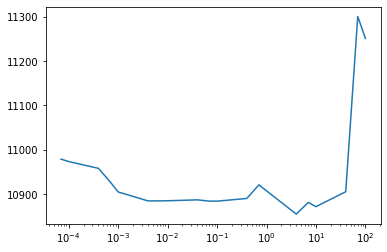

In [ ]:
# plot lr versus loss
lrs = history_Exp1Gp1.history['lr']
loss = history_Exp1Gp1.history['val_mae']
plt.semilogx(lrs, loss);

### Group 2: try `di_median` with lr $\leq$ 0.01

In [ ]:
feature_dim = train_kds_di_median.inputA[-1]
output_dim = train_kds_di_median.output[-1]

## !!! CHANGE MODEL NAME !!! ##
model_Exp1Gp2 = create_model(feature_dim, output_dim, 
                     user_embedding=typenet_base, 
                     keycode_embedding=None, 
                     concat_model=concate_RNN_base)

##------------------------------------------------------------------------------------------##
lr = 0.07
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_di_mean.ds
testset = test_kds_di_mean.ds
EPOCH = 20
patience = 4

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    lr = round(0.1 ** num1 * num2, 7)
    if lr < 0.01:
        return lr
    return 0.01

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = create_tensorboard_callback('Exp1Gp2', avg_mode=True)

model_Exp1Gp2.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)
history_Exp1Gp2 = model_Exp1Gp2.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/Exp1Gp2/20221206-063720-avg
Epoch 1/20
933/933 [==============================] - 37s 35ms/step - loss: 5609.0708 - mae: 5609.7681 - val_loss: 24029.8418 - val_mae: 24030.5508 - lr: 7.0000e-05
Epoch 2/20
933/933 [==============================] - 36s 39ms/step - loss: 5602.3403 - mae: 5603.0327 - val_loss: 24023.7598 - val_mae: 24024.4492 - lr: 1.0000e-04
Epoch 3/20
933/933 [==============================] - 36s 39ms/step - loss: 5587.6587 - mae: 5588.3477 - val_loss: 24000.1992 - val_mae: 24000.8887 - lr: 4.0000e-04
Epoch 4/20
933/933 [==============================] - 32s 34ms/step - loss: 5555.7461 - mae: 5556.4380 - val_loss: 23959.7168 - val_mae: 23960.3906 - lr: 7.0000e-04
Epoch 5/20
933/933 [==============================] - 31s 33ms/step - loss: 5515.7705 - mae: 5516.4492 - val_loss: 23924.9395 - val_mae: 23925.6152 - lr: 0.0010
Epoch 6/20
933/933 [==============================] - 31s 33ms/

KeyboardInterrupt: ignored

In [ ]:
for a, b in test_kds_di_mean.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds_di_mean.ds_out.take(1):
    output = a

model_Exp1Gp2.predict((inputA, inputB)), output

2/2 [==============================] - 1s 12ms/step


(array([[107.53589 , 224.28812 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.84769 , 224.4456  ],
        [107.849434, 224.44649 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849434, 224.44649 ],
        [104.21314 , 222.6099  ],
        [107.84947 , 224.4465  ],
        [107.849495, 224.44652 ],
        [107.849434, 224.44649 ],
        [107.849495, 224.44652 ],
        [107.84769 , 224.4456  ],
        [107.84936 , 224.44644 ],
        [107.849495, 224.44652 ],
        [107.84949 , 224.44652 ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.79295 , 224.41797 ],
        [107.849495, 224.44652 ],
        [107.84947 , 224.4465  ],
        [107.849495, 224.44652 ],
        [107.849495, 224.44652 ],
        [107.8

# New Experiments

## NewExp0: `sample_size = 100`, `train_size = 0.8`

Goal: 
1. have a baseline learning rate (just use one set of parameters)
2. decide `avg` should be `mean` or `median`

Preping mode: 
* add_layout = False
* remove_outliers = 1
* conn_latency = 'PL'
* n_steps = 30
* shift = 1
* batch_size = 64

Total trainings: 4

In [ ]:
## Data Loading Parameters
folder_path = "/content/drive/MyDrive/COMP576/keystroke-samples"      ## up to USER=7001 (inclusive)
train_size = 0.8
sample_size = 100

data, train_data, test_data, uni_encoder, di_encoder = prep.processing_folder(folder_path, sample_size, train_size)

print(f"There are in total {len(train_data['PARTICIPANT_ID'].unique())} many users contained in the train dataset")
print(f"There are in total {len(test_data['PARTICIPANT_ID'].unique())} many users contained in the test dataset")
print(f"There are in total {len(data['PARTICIPANT_ID'].unique())} many users contained in the entire dataset")
print(f"There are in total {len(data)} many keystrokes contained in the dataset")

There are in total 100 many users contained in the train dataset
There are in total 100 many users contained in the test dataset
There are in total 100 many users contained in the entire dataset
There are in total 74404 many keystrokes contained in the dataset


In [ ]:
latencies = ['HL', 'PL']

keyboard_dict = prep.Keyboard(prep.get_qwerty_keyboard()).keyboard_dict()
train_extractor = prep.Extractors(train_data, keyboard_dict, latencies, is_testset=False)
test_extractor = prep.Extractors(test_data, keyboard_dict, latencies, is_testset=True)

### Group 0

In [ ]:
avg_mode = 'mean'

train_df_uni_mean = train_extractor.unigraph_avg(avg_mode)
test_df_uni_mean = test_extractor.unigraph_avg(avg_mode)

n_steps = 30
shift = 1
batch_size = 64

train_kds_uni_mean = prep.KDS(train_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')
test_kds_uni_mean = prep.KDS(test_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')

In [ ]:
train_df_uni_mean.describe()

,USER,INDEX,HL,PL
count,58246.0,58246.0,58246.0,58246.0
mean,180.1,27.0,118.9,275.2
std,102.5,19.4,57.2,72.1
min,5.0,0.0,0.0,23.0
25%,88.0,11.0,105.0,232.0
50%,186.0,24.0,107.0,251.0
75%,275.0,39.0,113.0,284.0
max,346.0,134.0,1051.0,5329.0


In [ ]:
test_df_uni_mean.describe()

,USER,INDEX,HL,PL
count,14559.0,14559.0,14559.0,14559.0
mean,180.2,29.0,117.1,276.4
std,102.5,20.3,60.2,70.0
min,5.0,0.0,47.0,142.0
25%,88.0,13.0,103.0,242.0
50%,186.0,26.0,106.0,256.0
75%,275.0,42.0,113.0,292.0
max,346.0,117.0,981.0,1846.0


In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]
user_gru = 128
concat_gru = 64

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
concat_output = keras.layers.GRU(concat_gru)(reshape)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NewExp0Gp0'
model_NewExp0Gp0 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 13

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    lr = round(0.1 ** num1 * num2, 7)
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=True)

##change model name 3
model_NewExp0Gp0.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NewExp0Gp0 = model_NewExp0Gp0.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NewExp0Gp0/20221206-212725-avg
Epoch 1/13
909/909 [==============================] - 34s 33ms/step - loss: 189.3641 - mae: 190.0574 - val_loss: 185.5548 - val_mae: 186.2479 - lr: 7.0000e-05
Epoch 2/13
909/909 [==============================] - 28s 31ms/step - loss: 182.2309 - mae: 182.9241 - val_loss: 179.1468 - val_mae: 179.8400 - lr: 1.0000e-04
Epoch 3/13
909/909 [==============================] - 29s 32ms/step - loss: 166.9953 - mae: 167.6887 - val_loss: 154.9515 - val_mae: 155.6446 - lr: 4.0000e-04
Epoch 4/13
909/909 [==============================] - 28s 31ms/step - loss: 134.1049 - mae: 134.7980 - val_loss: 113.2508 - val_mae: 113.9431 - lr: 7.0000e-04
Epoch 5/13
909/909 [==============================] - 28s 31ms/step - loss: 91.4104 - mae: 92.0864 - val_loss: 75.9256 - val_mae: 76.6105 - lr: 0.0010
Epoch 6/13
909/909 [==============================] - 28s 31ms/step - loss: 38.4988 - mae: 39.

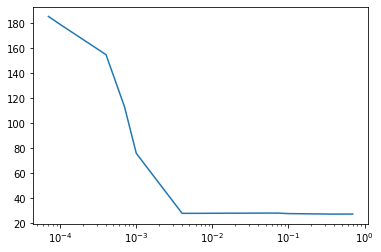

In [ ]:
lr_vs_loss(history_NewExp0Gp0)

> $≈0.001$ is a good learning rate

In [ ]:
for a, b in test_kds_uni_mean.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds_uni_mean.ds_out.take(1):
    output = a
model_NewExp0Gp0.predict((inputA, inputB))

2/2 [==============================] - 1s 11ms/step


array([[109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [109.23762, 247.13109],
       [

In [ ]:
inputA.shape, inputB.shape, output.shape

(TensorShape([64, 30, 80]), TensorShape([64, 78]), TensorShape([64, 2]))

In [ ]:
output

<tf.Tensor: shape=(64, 2), dtype=float64, numpy=
array([[  99.,  247.],
       [ 109.,  232.],
       [ 106.,  372.],
       [ 113.,  255.],
       [  86.,  304.],
       [ 101.,  236.],
       [ 113.,  255.],
       [ 106.,  372.],
       [ 131.,  256.],
       [ 106.,  372.],
       [ 102.,  216.],
       [ 104.,  263.],
       [ 104.,  242.],
       [ 104.,  242.],
       [ 104.,  263.],
       [ 103.,  274.],
       [ 102.,  217.],
       [ 106.,  372.],
       [  97.,  228.],
       [ 113.,  255.],
       [  97.,  228.],
       [ 111.,  241.],
       [ 113.,  256.],
       [ 104.,  263.],
       [ 131.,  256.],
       [  99.,  247.],
       [ 106.,  372.],
       [ 104.,  242.],
       [ 111.,  241.],
       [ 106.,  372.],
       [ 104.,  242.],
       [ 100.,  203.],
       [ 111.,  241.],
       [ 120.,  247.],
       [ 113.,  255.],
       [ 106.,  372.],
       [ 124.,  256.],
       [ 100.,  203.],
       [ 111.,  241.],
       [ 106.,  372.],
       [ 109.,  232.],
       [

#### Conclusion

Prediction output vectors are almost ALL the same!! Something is probably wrong with the model.

### Group 1 

* GRU as backbone of concat model --> Dense layer
* epoch 13 --> 10

In [ ]:
avg_mode = 'median'

train_df_uni_median = train_extractor.unigraph_avg(avg_mode)
test_df_uni_median = test_extractor.unigraph_avg(avg_mode)

n_steps = 30
shift = 1
batch_size = 64

train_kds_uni_median = prep.KDS(train_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')
test_kds_uni_median = prep.KDS(test_df_uni_mean, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')

> Ooooopsss, accidentally still used the mean data since forget to change `prep.KDS(train_df_uni_mean)`

In [ ]:
train_df_uni_median.describe()

,USER,INDEX,HL,PL
count,58246.0,58246.0,58246.0,58246.0
mean,180.1,27.0,106.4,185.3
std,102.5,19.4,29.8,43.5
min,5.0,0.0,0.0,23.0
25%,88.0,11.0,95.0,168.0
50%,186.0,24.0,103.0,176.0
75%,275.0,39.0,107.0,177.0
max,346.0,134.0,272.0,5329.0


In [ ]:
test_df_uni_median.describe()

,USER,INDEX,HL,PL
count,14559.0,14559.0,14559.0,14559.0
mean,180.2,29.0,107.2,190.2
std,102.5,20.3,31.3,44.9
min,5.0,0.0,47.0,142.0
25%,88.0,13.0,96.0,174.0
50%,186.0,26.0,103.0,179.0
75%,275.0,42.0,108.0,185.0
max,346.0,117.0,272.0,1846.0


In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]
user_gru = 64
# concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

# reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
# concat_output = keras.layers.GRU(concat_gru)(reshape)

dense_1 = keras.layers.Dense(60)(concat)
concat_output = keras.layers.Dense(30)(dense_1)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NewExp0Gp1'
model_NewExp0Gp1 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 10

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    lr = round(0.1 ** num1 * num2, 7)
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=True)

##change model name 3
model_NewExp0Gp1.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NewExp0Gp1 = model_NewExp0Gp1.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NewExp0Gp1/20221206-214948-avg
Epoch 1/10
909/909 [==============================] - 24s 23ms/step - loss: 110.2130 - mae: 110.9025 - val_loss: 47.3997 - val_mae: 48.0834 - lr: 7.0000e-05
Epoch 2/10
909/909 [==============================] - 22s 24ms/step - loss: 35.5307 - mae: 36.2048 - val_loss: 27.7815 - val_mae: 28.4526 - lr: 1.0000e-04
Epoch 3/10
909/909 [==============================] - 22s 24ms/step - loss: 25.5461 - mae: 26.2026 - val_loss: 23.8219 - val_mae: 24.4786 - lr: 4.0000e-04
Epoch 4/10
909/909 [==============================] - 21s 23ms/step - loss: 14.4531 - mae: 14.9566 - val_loss: 13.8998 - val_mae: 14.5222 - lr: 7.0000e-04
Epoch 5/10
909/909 [==============================] - 20s 22ms/step - loss: 7.3300 - mae: 7.6678 - val_loss: 13.3545 - val_mae: 13.9846 - lr: 0.0010
Epoch 6/10
909/909 [==============================] - 22s 24ms/step - loss: 7.5209 - mae: 8.1240 - val_loss: 1

> Loss aroun 0.001 is still the best

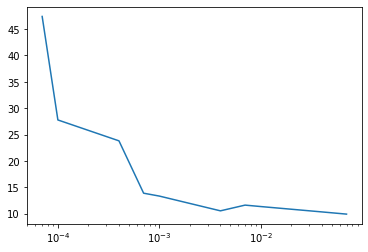

In [ ]:
lr_vs_loss(history_NewExp0Gp1)

In [ ]:
for a, b in test_kds_uni_median.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds_uni_median.ds_out.take(1):
    output = a
model_NewExp0Gp1.predict((inputA, inputB))

2/2 [==============================] - 1s 8ms/step


array([[ 97.225006, 223.56552 ],
       [111.63891 , 236.14406 ],
       [110.15482 , 375.402   ],
       [113.57613 , 237.90764 ],
       [ 91.411644, 307.00558 ],
       [ 94.30868 , 227.24858 ],
       [113.49027 , 237.56604 ],
       [110.012215, 374.83264 ],
       [129.07881 , 242.87149 ],
       [109.95508 , 374.60486 ],
       [104.79095 , 202.43713 ],
       [108.54989 , 239.14185 ],
       [103.37226 , 212.13908 ],
       [103.34362 , 212.02515 ],
       [108.46427 , 238.80031 ],
       [105.81512 , 256.8933  ],
       [103.0222  , 211.78677 ],
       [109.72649 , 373.69406 ],
       [104.616425, 225.53125 ],
       [113.11929 , 236.08562 ],
       [104.55938 , 225.30356 ],
       [107.99679 , 222.99197 ],
       [110.98541 , 251.96245 ],
       [108.20723 , 237.77553 ],
       [128.622   , 241.04955 ],
       [ 96.51155 , 220.71854 ],
       [109.46978 , 372.66895 ],
       [102.94408 , 210.43114 ],
       [107.796844, 222.19499 ],
       [109.38398 , 372.32748 ],
       [10

In [ ]:
output

<tf.Tensor: shape=(64, 2), dtype=float64, numpy=
array([[  99.,  247.],
       [ 109.,  232.],
       [ 106.,  372.],
       [ 113.,  255.],
       [  86.,  304.],
       [ 101.,  236.],
       [ 113.,  255.],
       [ 106.,  372.],
       [ 131.,  256.],
       [ 106.,  372.],
       [ 102.,  216.],
       [ 104.,  263.],
       [ 104.,  242.],
       [ 104.,  242.],
       [ 104.,  263.],
       [ 103.,  274.],
       [ 102.,  217.],
       [ 106.,  372.],
       [  97.,  228.],
       [ 113.,  255.],
       [  97.,  228.],
       [ 111.,  241.],
       [ 113.,  256.],
       [ 104.,  263.],
       [ 131.,  256.],
       [  99.,  247.],
       [ 106.,  372.],
       [ 104.,  242.],
       [ 111.,  241.],
       [ 106.,  372.],
       [ 104.,  242.],
       [ 100.,  203.],
       [ 111.,  241.],
       [ 120.,  247.],
       [ 113.,  255.],
       [ 106.,  372.],
       [ 124.,  256.],
       [ 100.,  203.],
       [ 111.,  241.],
       [ 106.,  372.],
       [ 109.,  232.],
       [

#### Conclusion

GRU concat layer is BAD. lr $≈0.001$ is GOOD. (naming convention is bad, forgot to change many places from `mean`-->`median`, so the dataset used to train is actually still `mean`)

### Group 2: trying multi-user to get a feel

* mean --> avg_mode = False
* keep Dense layer
* epoch 10 --> 15
* uniformize naming of variables (independent of hyperparams)

In [ ]:
avg_mode = False

train_df = train_extractor.unigraph
test_df = test_extractor.unigraph

n_steps = 30
shift = 1
batch_size = 64

train_kds = prep.KDS(train_df, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')
test_kds = prep.KDS(test_df, n_steps, shift, batch_size, encoder=uni_encoder, mode='uni')

In [ ]:
len(train_df['PL'].unique())

1852

In [ ]:
train_df.describe()

,USER,INDEX,HL,PL
count,58246.0,58246.0,58246.0,58246.0
mean,180.1,27.0,118.9,275.1
std,102.5,19.4,264.9,374.7
min,5.0,0.0,-63.0,0.0
25%,88.0,11.0,80.0,128.0
50%,186.0,24.0,103.0,180.0
75%,275.0,39.0,132.0,288.0
max,346.0,134.0,29164.0,23604.0


In [ ]:
feature_dim = train_kds.inputA[-1]
output_dim = train_kds.output[-1]
user_gru = 64
# concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

# reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
# concat_output = keras.layers.GRU(concat_gru)(reshape)

dense_1 = keras.layers.Dense(60)(concat)
concat_output = keras.layers.Dense(30)(dense_1)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NewExp0Gp2'
model_NewExp0Gp2 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds.ds
testset = test_kds.ds
EPOCH = 15

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    lr = round(0.1 ** num1 * num2, 7)
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=True)

##change model name 3
model_NewExp0Gp2.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NewExp0Gp2 = model_NewExp0Gp2.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NewExp0Gp2/20221206-221835-avg
Epoch 1/15
909/909 [==============================] - 25s 24ms/step - loss: 141.0952 - mae: 141.7855 - val_loss: 98.1198 - val_mae: 98.8077 - lr: 7.0000e-05
Epoch 2/15
909/909 [==============================] - 22s 24ms/step - loss: 98.5051 - mae: 99.1925 - val_loss: 96.4227 - val_mae: 97.1093 - lr: 1.0000e-04
Epoch 3/15
909/909 [==============================] - 20s 22ms/step - loss: 96.1477 - mae: 96.8348 - val_loss: 96.5652 - val_mae: 97.2522 - lr: 4.0000e-04
Epoch 4/15
909/909 [==============================] - 21s 23ms/step - loss: 95.8032 - mae: 96.4903 - val_loss: 97.0415 - val_mae: 97.7280 - lr: 7.0000e-04
Epoch 5/15
909/909 [==============================] - 22s 24ms/step - loss: 95.6707 - mae: 96.3576 - val_loss: 97.8181 - val_mae: 98.5045 - lr: 0.0010
Epoch 6/15
909/909 [==============================] - 22s 24ms/step - loss: 99.0011 - mae: 99.6889 - val_los

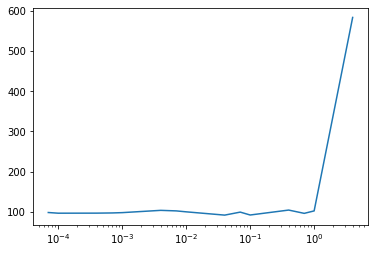

In [ ]:
lr_vs_loss(history_NewExp0Gp2)

In [ ]:
for a, b in test_kds.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds.ds_out.take(1):
    output = a
model_NewExp0Gp2.predict((inputA, inputB))

#### Conclusion

The traininng with multiple user "improved" a lot from previous trainings --> at least the loss looks more resonable now. 

However, given that the mean and median of the training data is around 200, the loss is not ideal. (This could be because we are experimenting with learning rate at the moment)

**Should try training HL and PL separately in NewExp1; to do that: need to modify KDS first**

> Forgot to turn `tensorboard` `avg_mode=False`

### Group 3 (from Group 1)

* avg_mode --> median
* uni --> di

In [ ]:
avg_mode = 'median'

train_df = train_extractor.digraph_avg(avg_mode)
test_df = test_extractor.digraph_avg(avg_mode)

n_steps = 30
shift = 1
batch_size = 64

train_kds = prep.KDS(train_df, n_steps, shift, batch_size, encoder=di_encoder, mode='di')
test_kds = prep.KDS(test_df, n_steps, shift, batch_size, encoder=di_encoder, mode='di')

In [ ]:
train_df.describe()

,USER,I1,I2,HL1,HL2,PL
count,58246.0,58246.0,58246.0,58246.0,58246.0,58246.0
mean,180.1,27.0,28.0,109.6,104.2,203.0
std,102.5,19.4,19.4,166.3,48.4,160.8
min,5.0,0.0,1.0,0.0,0.0,2.0
25%,88.0,11.0,12.0,96.0,95.0,151.0
50%,186.0,24.0,25.0,103.0,102.0,169.0
75%,275.0,39.0,40.0,110.0,110.0,216.0
max,346.0,134.0,135.0,14646.0,9460.0,23604.0


In [ ]:
feature_dim = train_kds.inputA[-1]
output_dim = train_kds.output[-1]
user_gru = 64
# concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

# reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
# concat_output = keras.layers.GRU(concat_gru)(reshape)

dense_1 = keras.layers.Dense(60)(concat)
concat_output = keras.layers.Dense(30)(dense_1)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NewExp0Gp3'
model_NewExp0Gp3 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds.ds
testset = test_kds.ds
EPOCH = 15

# def lr_finder(epoch):
#     num1 = 4 - (epoch - 1) // 3
#     num2 = 1 + (epoch - 1) % 3 * 3
#     lr = round(0.1 ** num1 * num2, 7)
#     return lr

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=avg_mode)

##change model name 3
model_NewExp0Gp3.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NewExp0Gp3 = model_NewExp0Gp3.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NewExp0Gp3/20221206-224424-avg
Epoch 1/15
909/909 [==============================] - 28s 27ms/step - loss: 32.3215 - mae: 32.9854 - val_loss: 28.4961 - val_mae: 29.1557
Epoch 2/15
909/909 [==============================] - 23s 26ms/step - loss: 23.8059 - mae: 24.4501 - val_loss: 27.5187 - val_mae: 28.1829
Epoch 3/15
909/909 [==============================] - 23s 25ms/step - loss: 22.4357 - mae: 23.0748 - val_loss: 26.7923 - val_mae: 27.4575
Epoch 4/15
909/909 [==============================] - 23s 26ms/step - loss: 21.4741 - mae: 22.1098 - val_loss: 26.3017 - val_mae: 26.9653
Epoch 5/15
909/909 [==============================] - 24s 26ms/step - loss: 20.8148 - mae: 21.4488 - val_loss: 25.8931 - val_mae: 26.5572
Epoch 6/15
909/909 [==============================] - 25s 27ms/step - loss: 20.3812 - mae: 21.0152 - val_loss: 25.5911 - val_mae: 26.2526
Epoch 7/15
909/909 [==============================] -

#### Conclusion

The model seems to need more training time. Let us try a high epoch with added EarlyStopping

### Group 4 (from Group 3)

* epoch --> 100
* earlystopping

In [ ]:
avg_mode = 'median'

train_df = train_extractor.digraph_avg(avg_mode)
test_df = test_extractor.digraph_avg(avg_mode)

n_steps = 30
shift = 1
batch_size = 64

train_kds = prep.KDS(train_df, n_steps, shift, batch_size, encoder=di_encoder, mode='di')
test_kds = prep.KDS(test_df, n_steps, shift, batch_size, encoder=di_encoder, mode='di')

In [ ]:
feature_dim = train_kds.inputA[-1]
output_dim = train_kds.output[-1]
user_gru = 64
# concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

# reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
# concat_output = keras.layers.GRU(concat_gru)(reshape)

dense_1 = keras.layers.Dense(60)(concat)
concat_output = keras.layers.Dense(30)(dense_1)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NewExp0Gp4'
model_NewExp0Gp4 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds.ds
testset = test_kds.ds
EPOCH = 100

# def lr_finder(epoch):
#     num1 = 4 - (epoch - 1) // 3
#     num2 = 1 + (epoch - 1) % 3 * 3
#     lr = round(0.1 ** num1 * num2, 7)
#     return lr

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
# tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=avg_mode)

##change model name 3
model_NewExp0Gp4.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NewExp0Gp4 = model_NewExp0Gp4.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=prep.get_callbacks(model_name, 4, avg_mode))

Saving ModelCheckpoint files to :/content/drive/MyDrive/COMP576/experiments/checkpoints/NewExp0Gp4/20221206-230646-avg
Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NewExp0Gp4/20221206-230646-avg
Epoch 1/100
909/909 [==============================] - 26s 25ms/step - loss: 33.0976 - mae: 33.7631 - val_loss: 28.6564 - val_mae: 29.3196
Epoch 2/100
909/909 [==============================] - 23s 25ms/step - loss: 23.8340 - mae: 24.4783 - val_loss: 27.5851 - val_mae: 28.2493
Epoch 3/100
909/909 [==============================] - 22s 24ms/step - loss: 22.4287 - mae: 23.0664 - val_loss: 26.8124 - val_mae: 27.4778
Epoch 4/100
909/909 [==============================] - 24s 26ms/step - loss: 21.4641 - mae: 22.0980 - val_loss: 26.3186 - val_mae: 26.9836
Epoch 5/100
909/909 [==============================] - 24s 26ms/step - loss: 20.8247 - mae: 21.4575 - val_loss: 25.9035 - val_mae: 26.5693
Epoch 6/100
909/909 [==============================] - 23s 25ms/ste

In [ ]:
for a, b in test_kds.ds_in.take(1):
    inputA = a
    inputB = b
for a in test_kds.ds_out.take(1):
    output = a
model_NewExp0Gp4.predict((inputA, inputB))

2/2 [==============================] - 1s 10ms/step


array([[105.450005, 147.36287 ],
       [103.19517 , 146.36296 ],
       [106.6376  , 208.12663 ],
       [ 76.378265, 446.91904 ],
       [ 89.04304 , 100.05393 ],
       [104.08657 , 143.08044 ],
       [102.950645, 141.02246 ],
       [126.86503 , 202.38203 ],
       [101.52219 , 152.60733 ],
       [102.79365 , 287.39413 ],
       [ 87.0023  , 135.38852 ],
       [ 95.58018 , 159.52689 ],
       [ 95.858604, 165.32254 ],
       [ 93.46136 , 164.71614 ],
       [ 97.92571 , 161.61295 ],
       [ 97.68009 , 146.93051 ],
       [102.73592 , 142.59111 ],
       [ 99.315   , 221.4344  ],
       [105.91718 , 138.64586 ],
       [ 99.90802 , 168.36176 ],
       [101.18175 , 163.59857 ],
       [104.58237 , 150.35895 ],
       [ 95.03734 , 155.19727 ],
       [126.18613 , 132.51065 ],
       [ 90.09935 , 169.27731 ],
       [ 97.92497 , 137.5647  ],
       [ 96.00238 , 223.25882 ],
       [100.249214, 124.70886 ],
       [103.38757 , 150.70656 ],
       [ 95.96989 , 222.99675 ],
       [ 9

In [ ]:
output

<tf.Tensor: shape=(64, 2), dtype=float64, numpy=
array([[120., 150.],
       [102., 144.],
       [114., 305.],
       [ 78., 442.],
       [104., 240.],
       [114., 190.],
       [104., 141.],
       [122., 198.],
       [109., 162.],
       [102., 304.],
       [ 96., 159.],
       [ 95., 181.],
       [ 96., 151.],
       [ 96., 150.],
       [ 96., 163.],
       [102., 138.],
       [ 99., 136.],
       [ 86., 230.],
       [105., 137.],
       [ 98., 168.],
       [ 96., 174.],
       [ 95., 163.],
       [106., 172.],
       [113., 157.],
       [ 80., 176.],
       [103., 166.],
       [ 97., 208.],
       [100., 129.],
       [108., 152.],
       [ 97., 208.],
       [ 93., 118.],
       [104., 150.],
       [105., 128.],
       [112., 185.],
       [104., 141.],
       [117., 242.],
       [102., 170.],
       [104., 150.],
       [108., 152.],
       [117., 233.],
       [ 96., 146.],
       [ 99., 145.],
       [113., 193.],
       [ 96., 259.],
       [ 80., 581.],
      

#### Conclusion

The performance is not bad, but also not ideal compared to uni-graph models. This could be because of the one-hot encoding on the pair of keycodes makes the feature inputs become 2X more sparse.

## NExp1: `sample_size = 100`, `train_size = 0.8`

**FIRST MODEL THAT WORKS "NORMALLY"!!**
from **10^12 loss --> 500 + 11080 loss --> within 10^2 loss!!, good job Xingya**

Goal: 
1. have a baseline learning rate (just use one set of parameters)
2. decide `avg` should be `mean` or `median`

Preping mode: 
* add_layout = False
* remove_outliers = 1
* conn_latency = 'PL'
* n_steps = 30
* shift = 1
* batch_size = 64

Total trainings: 8

In [ ]:
feature_dim = train_kds_uni_mean.inputA[-1]
output_dim = train_kds_uni_mean.output[-1]
user_gru = 64
concat_gru = 32

inputA = keras.layers.Input(shape=[None, feature_dim], name='InputA')
inputB = keras.layers.Input(shape=[feature_dim-output_dim], name='InputB')

batch_1 = keras.layers.BatchNormalization()(inputA)
gru_1 = keras.layers.GRU(user_gru, return_sequences=True)(batch_1)
dropout_1 = keras.layers.Dropout(0.5)(gru_1)
batch_2 = keras.layers.BatchNormalization()(dropout_1)
gru_out = keras.layers.GRU(user_gru)(batch_2)

concat = keras.layers.concatenate([gru_out, inputB])

reshape = keras.layers.Reshape((user_gru+feature_dim-output_dim, 1))(concat)
concat_output = keras.layers.GRU(concat_gru)(reshape)

output = keras.layers.Dense(output_dim)(concat_output)

##change model name 0
model_name = 'NExp1Gp0'
model_NExp1Gp0 = keras.Model(inputs=[inputA, inputB], outputs=[output], name=model_name)

In [ ]:
lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.LogCosh()
metrics = ['mae']

trainset = train_kds_uni_mean.ds
testset = test_kds_uni_mean.ds
EPOCH = 20
patience = 4

def lr_finder(epoch):
    num1 = 4 - (epoch - 1) // 3
    num2 = 1 + (epoch - 1) % 3 * 3
    lr = round(0.1 ** num1 * num2, 7)
    if lr < 0.01:
        return lr
    return 0.01

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_finder)
tensorboard = prep.create_tensorboard_callback(model_name, avg_mode=True)

##change model name 3
model_NExp1Gp0.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=metrics)

##change model name 4 + 5
history_NExp1Gp0 = model_NExp1Gp0.fit(trainset, epochs=EPOCH, validation_data=testset, callbacks=[lr_scheduler, tensorboard])

Saving TensorBoard log files to :/content/drive/MyDrive/COMP576/experiments/tensorboard/NExp1Gp0/20221206-210429-avg
Epoch 1/20
909/909 [==============================] - 35s 30ms/step - loss: 193.3844 - mae: 194.0775 - val_loss: 190.2764 - val_mae: 190.9695 - lr: 7.0000e-05
Epoch 2/20
909/909 [==============================] - 25s 27ms/step - loss: 188.1275 - mae: 188.8205 - val_loss: 186.4287 - val_mae: 187.1219 - lr: 1.0000e-04
Epoch 3/20
909/909 [==============================] - 25s 27ms/step - loss: 179.9754 - mae: 180.6683 - val_loss: 173.7352 - val_mae: 174.4283 - lr: 4.0000e-04
Epoch 4/20
909/909 [==============================] - 25s 27ms/step - loss: 162.9701 - mae: 163.6637 - val_loss: 152.3162 - val_mae: 153.0093 - lr: 7.0000e-04
Epoch 5/20
909/909 [==============================] - 25s 27ms/step - loss: 137.1953 - mae: 137.8885 - val_loss: 122.1051 - val_mae: 122.7983 - lr: 0.0010
Epoch 6/20
909/909 [==============================] - 25s 27ms/step - loss: 80.9242 - mae: 8

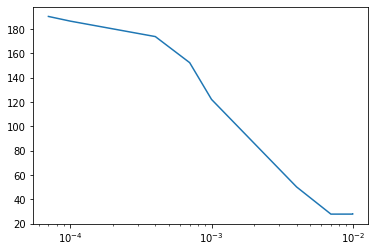

In [ ]:
lr_vs_loss(history_NExp1Gp0)